In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from collections import Counter, defaultdict
from scipy import stats

# Load

In [ ]:
ship_df = pd.read_parquet('SHIP.parquet.gzip')

In [ ]:
ship_df.head()

In [ ]:
ukb_df = pd.read_parquet('ECG.orig_val.parquet.gzip')

In [ ]:
ukb_df.head()

# Compare

In [ ]:
ukb_df.describe()

In [ ]:
ship_df.describe()

In [ ]:
num_cols = ['LVM', 'indexed.LVM', 'Av_SBP', 'Av_DBP', 'Age', 'BMI', 'non.hdl.chol', 'total.chol', 'Ventricular_rate']
cat_cols = ['htn.defined', 'Sex', 'diabetes_final', 'chol_final', 'alcohol.status', 'smoking.status', 'ethnicity']

In [ ]:
def _contingency_table(xs, ys):
    df1 = pd.DataFrame.from_dict(Counter(xs), orient='index', columns=['Count1'])
    df2 = pd.DataFrame.from_dict(Counter(ys), orient='index', columns=['Count2'])
    return df1.merge(df2, left_index=True, right_index=True, how='outer').fillna(0)

In [ ]:
recs = []

cat_cols_v = set()
samples = defaultdict(lambda: defaultdict(lambda: defaultdict()))
for group in ship_df['LVM.group'].unique():
    ship_lvm_df = ship_df[ship_df['LVM.group'] == group]
    ukb_lvm_df = ukb_df[ukb_df['LVM.group'] == group]
    for num_col in num_cols:
        ship_col = ship_lvm_df[num_col]
        ukb_col = ukb_lvm_df[num_col]
        ship_mean, ship_std = ship_col.agg(['median', 'std'])
        ukb_mean, ukb_std = ukb_col.agg(['median', 'std'])
        t_stat, p_val = stats.ttest_ind(ship_col, ukb_col, equal_var=False, nan_policy='omit')
        samples['ukb'][num_col][group] = ukb_col
        samples['ship'][num_col][group] = ship_col
        recs.append([num_col, None, group, ukb_mean, ukb_std, ship_mean, ship_std, t_stat, p_val])
    
    for cat_col in cat_cols:
        ship_col = ship_lvm_df[cat_col]
        ukb_col = ukb_lvm_df[cat_col]
        all_values = np.sort(np.unique(np.hstack([ship_col.unique(), ukb_col.unique()])))
        for v in all_values:
            stat, p = None, None
            ship_col_v = (ship_col == v).astype(int)
            ukb_col_v = (ukb_col == v).astype(int)
            samples['ukb'][f"{cat_col}_{v}"][group] = ukb_col_v
            samples['ship'][f"{cat_col}_{v}"][group] = ship_col_v
            cat_cols_v.add(f"{cat_col}_{v}")
            if np.isnan(v): 
                continue
            else:
                tbl = _contingency_table(ship_col_v, ukb_col_v)
                if tbl.shape[0] > 1:
                    stat, p = stats.fisher_exact(tbl)
            recs.append([cat_col, v, group, ukb_col_v.sum(), 100*ukb_col_v.sum()/ukb_col.shape[0], ship_col_v.sum(), 100*ship_col_v.sum()/ship_col.shape[0], stat, p])

In [ ]:
for k, s in samples.items():
    for num_col in num_cols:
        stat, p = stats.ttest_ind(s[num_col][1], s[num_col][2], equal_var=False, nan_policy='omit')
        print(k, num_col, p)
    for cat_col_v in cat_cols_v:
        try:
            tbl = _contingency_table(s[cat_col_v][1], s[cat_col_v][2])
            if tbl.shape[0] > 1:
                stat, p = stats.fisher_exact(tbl)
                print(k, cat_col_v, p)
        except:
            pass

In [ ]:
summ_df = pd.DataFrame(recs, columns=['Col', 'Value', 'LVM.group', 'UKB_N/Med', 'UKB_Perc/SD', 'SHIP_N/Med', 'SHIP_Perc/SD', 'stat', 'pvalue'])
summ_df['pvalue_str'] = summ_df['pvalue'].apply(lambda x: '< 0.001' if x < 0.001 else str(np.round(x, 5)))
summ_df['LVM.group'] = summ_df['LVM.group'].apply(lambda x: 'LVH' if x == 1 else 'Normal')
summ_df.sort_values(by=['Col','LVM.group'])

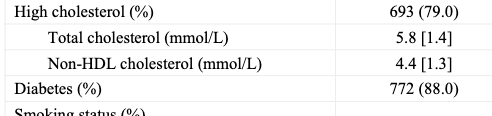

In [ ]:
for col in ['diabetes_final', 'chol_final', 'ethnicity','alcohol.status', 'smoking.status',  ]:
    print('> ', col)
    print(ship_df[col].value_counts())
    print(ukb_df[col].value_counts())
    print()

---

In [ ]:
recs = []

cat_cols_v = set()
samples = defaultdict(lambda: defaultdict())
for num_col in num_cols:
    ship_col = ship_df[num_col]
    ukb_col = ukb_df[num_col]
    ship_mean, ship_std = ship_col.agg(['median', 'std'])
    ukb_mean, ukb_std = ukb_col.agg(['median', 'std'])
    t_stat, p_val = stats.ttest_ind(ship_col, ukb_col, equal_var=False, nan_policy='omit')
    samples['ukb'][num_col] = ukb_col
    samples['ship'][num_col] = ship_col
    recs.append([num_col, None, ukb_mean, ukb_std, ship_mean, ship_std, t_stat, p_val])

for cat_col in cat_cols:
    ship_col = ship_df[cat_col]
    ukb_col = ukb_df[cat_col]
    all_values = np.sort(np.unique(np.hstack([ship_col.unique(), ukb_col.unique()])))
    for v in all_values:
        stat, p = None, None
        ship_col_v = (ship_col == v).astype(int)
        ukb_col_v = (ukb_col == v).astype(int)
        samples['ukb'][f"{cat_col}_{v}"] = ukb_col_v
        samples['ship'][f"{cat_col}_{v}"] = ship_col_v
        cat_cols_v.add(f"{cat_col}_{v}")
        if np.isnan(v): 
            continue
        else:
            tbl = _contingency_table(ship_col_v, ukb_col_v)
            if tbl.shape[0] > 1:
                stat, p = stats.fisher_exact(tbl)
        recs.append([cat_col, v, ukb_col_v.sum(), 100*ukb_col_v.sum()/ukb_col.shape[0], ship_col_v.sum(), 100*ship_col_v.sum()/ship_col.shape[0], stat, p])

In [ ]:
for k, s in samples.items():
    for num_col in num_cols:
        stat, p = stats.ttest_ind(s[num_col][1], s[num_col][2], equal_var=False, nan_policy='omit')
        print(k, num_col, p)
    for cat_col_v in cat_cols_v:
        try:
            tbl = _contingency_table(s[cat_col_v][1], s[cat_col_v][2])
            if tbl.shape[0] > 1:
                stat, p = stats.fisher_exact(tbl)
                print(k, cat_col_v, p)
        except:
            pass

In [ ]:
summ_df = pd.DataFrame(recs, columns=['Col', 'Value', 'UKB_N/Med', 'UKB_Perc/SD', 'SHIP_N/Med', 'SHIP_Perc/SD', 'stat', 'pvalue'])
summ_df['pvalue_str'] = summ_df['pvalue'].apply(lambda x: '< 0.001' if x < 0.001 else str(np.round(x, 5)))
summ_df.sort_values(by=['Col'])

In [ ]:
for col in ['Sex', 'ethnicity', 'diabetes_final', 'chol_final', 'ethnicity','alcohol.status', 'smoking.status',  ]:
    print('> ', col)
    print(ship_df[col].value_counts())
    print(ship_df[col].value_counts()/ship_df.shape[0])
    print(ukb_df[col].value_counts())
    print(ukb_df[col].value_counts()/ukb_df.shape[0])
    print()